In [1]:
import os
if os.getcwd().endswith('/notebook'):
    os.chdir('..')

In [2]:
import ontonotes
from ontonotes import ontonotes_en, OntonotesDocument

In [3]:
import sys
def print_conllx(deps, file=sys.stdout):
    ''' 
    Convert from my custom representation back to CoNLL-X format.
    This is useful for visualization using Arne Köhn's jupyter-annodoc.
    '''
    table = [(i+1, d['token'], '_', d['pos'], d['pos'], '_', d['head']+1, d['label'], '_', '_')
             for i, d in enumerate(deps)]
    print('\n'.join('\t'.join(str(val) for val in row) 
                    for row in table))
    print()

In [4]:
num_total = len(ontonotes.list_docs(ontonotes_en))
print("Number of OntoNotes documents:", num_total)

Number of OntoNotes documents: 13108


In [5]:
coref_files = [p + '.coref' for p in ontonotes.list_docs(ontonotes_en)]
num_coref = sum(1 for p in coref_files if os.path.exists(p))
print("With coreference data: %d (%.1f%%)" %(num_coref, 100*num_coref/num_total))

With coreference data: 2384 (18.2%)


I decided to fitler out all the names (determined as tokens with "NNP" and "NNPS" part-of-speech). Before doing so, I look up corefering expressions to see if we could replace the name with something more generic such as a pronoun or a noun. The coverage of coreference annotation is not that good (18.2% of documents) but better little than nothing.

In [6]:
def find_common_noun(doc, head_sent, head_tok):
    my_token = doc.deps()[head_sent][head_tok]['token']
    my_pos = doc.deps()[head_sent][head_tok]['pos']
    if my_pos.startswith('NNP'):
        my_token = '<NAME>'
    elif my_pos == 'PRP$':
        my_token = '<PRP$>'
    if my_pos.startswith('NNP') or my_pos == 'PRP$':
        corefs = doc.coref().get((head_sent, head_tok)) or []
        coref_toks = [doc.deps()[sent][tok] for sent, tok in corefs]
        common_nouns = [t['token'] for t in coref_toks if t['pos'] in ('NN', 'NNS')]
        pronouns = [t['token'] for t in coref_toks if t['pos'] == 'PRP']
        my_token = (common_nouns + pronouns + [my_token])[0]
    return my_token

In [7]:
import sys
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def extract_triples():
    triples = []
    for doc_path in tqdm(ontonotes.list_docs(ontonotes_en)):
        doc = OntonotesDocument(doc_path)
        for sent, sent_deps in enumerate(doc.deps()):
            dobjs = [(i, d) for i, d in enumerate(sent_deps) 
                     if d['label'] == 'dobj' and 
                     d['pos'].startswith('N') and 
                     d['token'] != '%']
            for dobj_idx, dobj in dobjs:
                verb_index = dobj['head']
                verb = sent_deps[verb_index]
                sbjs = [(i, d) for i, d in enumerate(sent_deps) 
                        if d['head'] == verb_index and
                        d['pos'].startswith('N') and
                        d['token'] != '%' and
                        d['label'] in ('nsubj', 'nsubjpass', 'xsubj', 'subj')]
                for sbj_idx, sbj in sbjs:
                    sbj_lemma = lemmatizer.lemmatize(find_common_noun(doc, sent, sbj_idx).lower(), pos='n')
                    verb_lemma = lemmatizer.lemmatize(verb['token'].lower(), pos='v')
                    dobj_lemma = lemmatizer.lemmatize(find_common_noun(doc, sent, dobj_idx).lower(), pos='n')
                    triples.append((sbj_lemma, verb_lemma, dobj_lemma))
    return triples

In [8]:
triples_with_names = extract_triples()

  0%|          | 7/13108 [00:03<1:35:58,  2.28it/s]<coref> head not found for "Wal - Mart" in sentence 73, file data/ontonotes-release-5.0/data/files/data/english/annotations/bc/cnn/00/cnn_0001.coref
<coref> head not found for "A Democrat from Nebraska a state that went Bush in oh four Nelson" in sentence 374, file data/ontonotes-release-5.0/data/files/data/english/annotations/bc/cnn/00/cnn_0001.coref
  0%|          | 10/13108 [00:03<1:17:53,  2.80it/s]<coref> head not found for "and Wade" in sentence 185, file data/ontonotes-release-5.0/data/files/data/english/annotations/bc/cnn/00/cnn_0004.coref
<coref> head not found for "Dick Cheney" in sentence 198, file data/ontonotes-release-5.0/data/files/data/english/annotations/bc/cnn/00/cnn_0004.coref
  0%|          | 18/13108 [00:04<55:33,  3.93it/s]  <coref> head not found for "the old liberal who really came through during the Cuban Missile Crisis because everybody in the world believed he was n't a hawk" in sentence 222, file data/ontono

  1%|          | 118/13108 [00:05<10:47, 20.05it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bc/p2.5_c2e/00/p2.5_c2e_0057.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bc/p2.5_c2e/00/p2.5_c2e_0058.coref, assume no coreference.
<coref> head not found for "Seismology Bureau" in sentence 7, file data/ontonotes-release-5.0/data/files/data/english/annotations/bc/phoenix/00/phoenix_0002.coref
<coref> head not found for "Qinglong County" in sentence 89, file data/ontonotes-release-5.0/data/files/data/english/annotations/bc/phoenix/00/phoenix_0002.coref
  5%|▌         | 694/13108 [00:08<02:29, 82.97it/s]<coref> head not found for "103 Pan Am" in sentence 24, file data/ontonotes-release-5.0/data/files/data/english/annotations/bn/nbc/00/nbc_0039.coref
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_a2e/00/p2.5_a2e_0003.coref, assume no coreference.
File not f

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0022.coref, assume no coreference.
  6%|▌         | 766/13108 [00:08<02:18, 89.40it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0024.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0025.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0026.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0027.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0028.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/bn/p2.5_c2e/00/p2.5_c2e_0031.coref, assume

<coref> head not found for "the Sogo in Taipei" in sentence 13, file data/ontonotes-release-5.0/data/files/data/english/annotations/mz/sinorama/10/ectb_1057.coref
<coref> head not found for "a florist who often works for the television and entertainment industries" in sentence 68, file data/ontonotes-release-5.0/data/files/data/english/annotations/mz/sinorama/10/ectb_1057.coref
<coref> head not found for "a plumber who runs the Democracy Association" in sentence 36, file data/ontonotes-release-5.0/data/files/data/english/annotations/mz/sinorama/10/ectb_1059.coref
<coref> head not found for "The most important Taiwanese musical master of the last half century , he" in sentence 73, file data/ontonotes-release-5.0/data/files/data/english/annotations/mz/sinorama/10/ectb_1060.coref
<coref> head not found for "Wang 's widow" in sentence 135, file data/ontonotes-release-5.0/data/files/data/english/annotations/mz/sinorama/10/ectb_1063.coref
<coref> head not found for "Many others at the same t

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0022.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0023.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0025.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0027.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0028.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0030.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/p2.5_a2e/00/p2.5_a2e_0031.coref, assume no coreference.
 10%|█         | 1359/13108 [00:12

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0023.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0024.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0034.coref, assume no coreference.
 11%|█▏        | 1488/13108 [00:12<01:38, 117.37it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0035.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0036.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0039.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/00/wsj_0041.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

 12%|█▏        | 1590/13108 [00:13<01:36, 119.77it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0180.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0181.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0182.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0183.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0186.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0192.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/01/wsj_0193.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

 13%|█▎        | 1701/13108 [00:13<01:31, 124.36it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0305.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0307.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0309.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0310.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0311.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0314.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/03/wsj_0318.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0455.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0456.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0458.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0460.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0461.coref, assume no coreference.
 14%|█▍        | 1810/13108 [00:14<01:28, 128.24it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0463.coref, assume no coreference.
<coref> head not found for "Johns Hopkins" in sentence 84, file data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/04/wsj_0465.coref
File not found: data/ontono

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/05/wsj_0580.coref, assume no coreference.
 15%|█▍        | 1910/13108 [00:14<01:25, 130.67it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/06/wsj_0600.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/06/wsj_0601.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/06/wsj_0604.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/06/wsj_0606.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/06/wsj_0607.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/06/wsj_0608.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0758.coref, assume no coreference.
 16%|█▌        | 2047/13108 [00:15<01:22, 134.27it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0759.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0761.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0764.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0765.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0766.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/07/wsj_0767.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

 16%|█▋        | 2144/13108 [00:15<01:20, 136.26it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0961.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0962.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0964.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0965.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0966.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0967.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/09/wsj_0968.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

 20%|█▉        | 2616/13108 [00:18<01:14, 140.96it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1616.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1617.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1620.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1623.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1624.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1628.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/16/wsj_1630.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1748.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1750.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1751.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1754.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1755.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1758.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/17/wsj_1759.coref, assume no coreference.
 21%|██        | 2714/13108 [00:18<01:12, 142.90it/s]File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1870.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1872.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1873.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1874.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1877.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1878.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1886.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/18/wsj_1887.coref,

 22%|██▏       | 2901/13108 [00:19<01:10, 145.60it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2021.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2023.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2024.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2025.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2030.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2031.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/20/wsj_2032.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

 23%|██▎       | 3004/13108 [00:20<01:08, 147.30it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2159.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2160.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2161.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2162.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2167.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2170.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/nw/wsj/21/wsj_2171.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/09/ot_0928.coref, assume no coreference.
 29%|██▉       | 3802/13108 [00:26<01:05, 142.33it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/09/ot_0929.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/09/ot_0930.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/09/ot_0931.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/10/ot_1001.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/10/ot_1002.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/10/ot_1003.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/englis

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1214.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1215.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1216.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1217.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1218.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1219.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1220.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/pt/ot/12/ot_1221.coref, assume no coref

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00/dev_09_c2e_0050.coref, assume no coreference.
 31%|███       | 4082/13108 [00:30<01:08, 132.46it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00/dev_09_c2e_0056.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00/dev_09_c2e_0065.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00/dev_09_c2e_0068.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00/dev_09_c2e_0071.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00/dev_09_c2e_0072.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/dev_09_c2e/00

 32%|███▏      | 4248/13108 [00:32<01:07, 132.11it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0020.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0023.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0024.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0026.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0027.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0028.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/p2.5_c2e/00/p2.5_c2e_0034.coref, assu

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0708.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0719.coref, assume no coreference.
 38%|███▊      | 5037/13108 [00:32<00:52, 155.19it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0731.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0733.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0735.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0740.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/07/sel_0745.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/14/sel_1491.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/14/sel_1493.coref, assume no coreference.
 44%|████▍     | 5806/13108 [00:32<00:41, 177.79it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/15/sel_1519.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/15/sel_1521.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/15/sel_1526.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/15/sel_1545.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/15/sel_1547.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/22/sel_2283.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/22/sel_2289.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/22/sel_2291.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/22/sel_2299.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/23/sel_2304.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/23/sel_2305.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/23/sel_2307.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/23/sel_2310.coref,

 57%|█████▋    | 7516/13108 [00:33<00:24, 225.91it/s]File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3217.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3243.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3249.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3261.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3273.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3276.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/files/data/english/annotations/wb/sel/32/sel_3294.coref, assume no coreference.
File not found: data/ontonotes-release-5.0/data/fil

In [9]:
print("Number of triples with names:", len(triples_with_names))

Number of triples with names: 28687


In [10]:
triples_without_names = [t for t in triples_with_names if '<name>' not in t]
print("Number of triples without names:", len(triples_without_names))

Number of triples without names: 20885


In [12]:
100 * len(triples_without_names) / len(triples_with_names)

72.80301181719943

So we ended up removing 25% of the data but in return, the training and testing won't be skewed towards the weird `<name>` tokens.

In [13]:
triples_without_names_or_possessive_pronouns = [t for t in triples_without_names if '<PRP$>' not in t]
print("Number of triples without names or possessive pronouns:", len(triples_without_names_or_possessive_pronouns))

Number of triples without names or possessive pronouns: 20885


In [33]:
import pandas as pd
df = pd.DataFrame(triples_without_names_or_possessive_pronouns, columns=['sbj', 'verb', 'dobj'])

In [34]:
df.to_csv('output/ontonote-svo.txt', sep='\t', index=False, header=False)

# Examine the data

In [35]:
%matplotlib inline
import random

In [36]:
df.sample(5)

,sbj,verb,dobj
6707,trust,consider,sale
15289,branch,have,lot
10520,him,return,call
16816,voice,say,man
7284,office,have,computer


In [37]:
df.describe()

,sbj,verb,dobj
count,20885,20885,20885
unique,2988,1688,3653
top,he,have,people
freq,787,2018,213


In [38]:
len(df['sbj'].unique())

2988

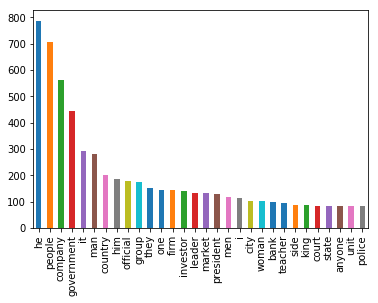

In [39]:
_ = df['sbj'].value_counts().head(30).plot('bar')

In [40]:
len(df['verb'].unique())

1688

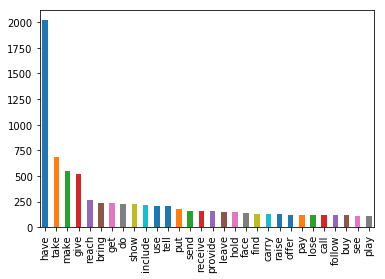

In [41]:
_ = df['verb'].value_counts().head(30).plot('bar')

In [42]:
len(df['dobj'].unique())

3653

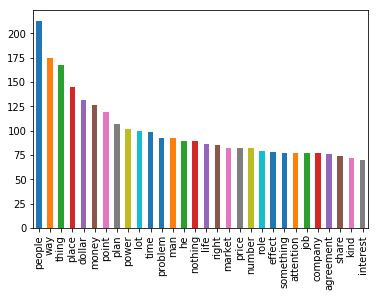

In [43]:
_ = df['dobj'].value_counts().head(30).plot('bar')

In [44]:
from collections import Counter
sbj_verb_freqs = Counter(tuple(row) for row in df[['sbj', 'verb']].values)
sbj_dobj_freqs = Counter(tuple(row) for row in df[['sbj', 'dobj']].values)
dobj_freqs = Counter(df['dobj'].values)
df_examine = df.copy()
df_examine['sbj_verb_freq'] = df.apply(lambda row: sbj_verb_freqs[(row['sbj'], row['verb'])], axis=1)
df_examine['sbj_dobj_freq'] = df.apply(lambda row: sbj_dobj_freqs[(row['sbj'], row['dobj'])], axis=1)
df_examine['dobj_freq'] = df.dobj.apply(lambda x: dobj_freqs[x])

In [45]:
sorted_df = df_examine[df_examine.sbj_verb_freq >= 2].sort_values(['sbj_verb_freq', 'sbj', 'verb'], ascending=False)

In [46]:
i = random.randint(0, len(sorted_df)-10)
sorted_df.iloc[i:i+10]

,sbj,verb,dobj,sbj_verb_freq,sbj_dobj_freq,dobj_freq
16758,you,bless,believer,3,1,5
12268,year,see,drop,3,1,22
18805,year,see,rise,3,1,27
20029,year,see,degree,3,1,9
61,year,mark,anniversary,3,3,5
88,year,mark,anniversary,3,3,5
19326,year,mark,anniversary,3,3,5
2930,writer,have,something,3,1,77
3662,writer,have,orientation,3,1,1
19056,writer,have,model,3,1,14


In [47]:
sorted_df2 = df_examine[df_examine.sbj_dobj_freq >= 2].sort_values(['sbj_dobj_freq', 'sbj', 'dobj'], ascending=False)
len(sorted_df2)

4986

In [48]:
i = random.randint(0, len(sorted_df2)-10)
sorted_df2.iloc[i:i+10]

,sbj,verb,dobj,sbj_verb_freq,sbj_dobj_freq,dobj_freq
7056,company,enter,business,12,3,46
12363,company,pool,business,1,3,46
4548,company,lack,asset,2,3,27
14919,company,utilize,asset,2,3,27
18810,company,get,asset,5,3,27
16935,commander,tell,man,3,3,92
16946,commander,lead,man,2,3,92
16947,commander,send,man,1,3,92
14614,city,issue,series,3,3,32
15067,city,adopt,series,1,3,32


In [49]:
sorted_df3 = df_examine[df_examine.dobj_freq >= 2].sort_values(['dobj_freq', 'dobj'], ascending=False)

In [50]:
i = random.randint(0, len(sorted_df3)-10)
sorted_df3.iloc[i:i+10]

,sbj,verb,dobj,sbj_verb_freq,sbj_dobj_freq,dobj_freq
18655,threshold,set,yuan,1,1,64
19066,project,total,yuan,1,2,64
19069,investment,reach,yuan,9,6,64
19082,amount,reach,yuan,9,2,64
19231,donation,exceed,yuan,1,1,64
1282,he,concede,loss,2,2,61
4173,group,feel,loss,1,1,61
5789,corruption,cause,loss,2,2,61
7066,stock,post,loss,4,2,61
7072,stock,have,loss,2,2,61


In [51]:
df[df.verb == 'buy']

,sbj,verb,dobj
269,everyone,buy,message
1179,member,buy,share
1251,father,buy,food
1254,parent,buy,thing
1844,company,buy,name
1889,people,buy,stock
1953,business,buy,machine
2109,he,buy,stake
2110,he,buy,rest
2211,fisherman,buy,glass
